In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

from utils.dataframe import read_final_csv

df = read_final_csv("random_forest")

In [19]:
from utils.dataframe import delete_columns

last_n_matches = [5, 10, 20, 50]
df = delete_columns(df, last_n_matches)

In [20]:
correlations = df.corr(numeric_only=True)['player_1_won'].drop('player_1_won')
sorted_corrs = correlations.abs().sort_values(ascending=False)

# To see actual signed correlation (not just abs value)
strongest_corrs = correlations.loc[sorted_corrs.index]
print(strongest_corrs)

elo_diff                  0.373932
surface_elo_diff          0.357306
last_20_match_diff        0.324387
last_20_win_ratio_diff    0.324387
last_10_match_diff        0.316138
                            ...   
surface_Clay              0.000872
tourney_level_G           0.000685
draw_size                 0.000618
tourney_level_D           0.000594
player_2_entry_Alt       -0.000005
Name: player_1_won, Length: 64, dtype: float64


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105733 entries, 0 to 105732
Data columns (total 65 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Unnamed: 0                     105733 non-null  int64  
 1   player_1_ioc                   105733 non-null  int64  
 2   player_1_entry_ALT             105733 non-null  bool   
 3   player_1_entry_Alt             105733 non-null  bool   
 4   player_1_entry_LL              105733 non-null  bool   
 5   player_1_entry_PR              105733 non-null  bool   
 6   player_1_entry_Q               105733 non-null  bool   
 7   player_1_entry_SE              105733 non-null  bool   
 8   player_1_entry_WC              105733 non-null  bool   
 9   player_1_hand_L                105733 non-null  bool   
 10  player_1_hand_R                105733 non-null  bool   
 11  player_1_was_seeded            105733 non-null  bool   
 12  player_2_ioc                  

In [22]:
x = df.drop("player_1_won", axis=1)
y = df["player_1_won"]

In [23]:
split_year = 2022

x_train = df[df["tourney_year"] < split_year].drop("player_1_won", axis=1)
y_train = df[df["tourney_year"] < split_year]["player_1_won"]

x_test = df[df["tourney_year"] >= split_year].drop("player_1_won", axis=1)
y_test = df[df["tourney_year"] >= split_year]["player_1_won"]

In [24]:
x_train.tail()

,Unnamed: 0,player_1_ioc,player_1_entry_ALT,player_1_entry_Alt,player_1_entry_LL,player_1_entry_PR,player_1_entry_Q,player_1_entry_SE,player_1_entry_WC,player_1_hand_L,...,elo_diff,surface_elo_diff,player_1_last_5_elo_progress,player_2_last_5_elo_progress,player_1_last_10_elo_progress,player_2_last_10_elo_progress,player_1_last_20_elo_progress,player_2_last_20_elo_progress,player_1_last_50_elo_progress,player_2_last_50_elo_progress
96920,96852,62,False,False,False,False,False,False,False,False,...,388.783529,406.579936,0.994657,0.989698,1.005164,1.019310,0.999011,1.008830,1.007500,1.036396
96921,96859,30,False,False,False,False,False,False,False,False,...,185.330405,234.107573,0.996769,1.024608,0.966305,1.007383,0.947410,1.021851,0.926947,1.058700
96922,96860,16,False,False,False,False,False,False,False,False,...,-387.749876,-405.098214,0.990716,1.000225,1.017396,1.013723,0.987131,1.025981,0.960577,1.037150
96923,96857,17,False,False,False,False,False,False,False,False,...,-298.011394,-279.899788,1.010541,0.990128,1.010342,0.978270,1.010342,0.953640,1.010342,0.927520
96924,96858,17,False,False,False,False,False,False,False,False,...,-297.050506,-350.916553,0.980002,0.997603,1.009264,1.008306,1.008780,1.025771,1.040699,1.036395


array([[<Axes: title={'center': 'Unnamed: 0'}>,
        <Axes: title={'center': 'player_1_ioc'}>,
        <Axes: title={'center': 'player_2_ioc'}>,
        <Axes: title={'center': 'draw_size'}>,
        <Axes: title={'center': 'tourney_year'}>,
        <Axes: title={'center': 'tourney_month'}>],
       [<Axes: title={'center': 'tourney_day'}>,
        <Axes: title={'center': 'rank_diff'}>,
        <Axes: title={'center': 'rank_points_diff'}>,
        <Axes: title={'center': 'seed_diff'}>,
        <Axes: title={'center': 'height_diff'}>,
        <Axes: title={'center': 'age_diff'}>],
       [<Axes: title={'center': 'h2h_diff'}>,
        <Axes: title={'center': 'surface_h2h_diff'}>,
        <Axes: title={'center': 'total_match_diff'}>,
        <Axes: title={'center': 'won_match_diff'}>,
        <Axes: title={'center': 'last_5_match_diff'}>,
        <Axes: title={'center': 'last_10_match_diff'}>],
       [<Axes: title={'center': 'last_20_match_diff'}>,
        <Axes: title={'center': 'las

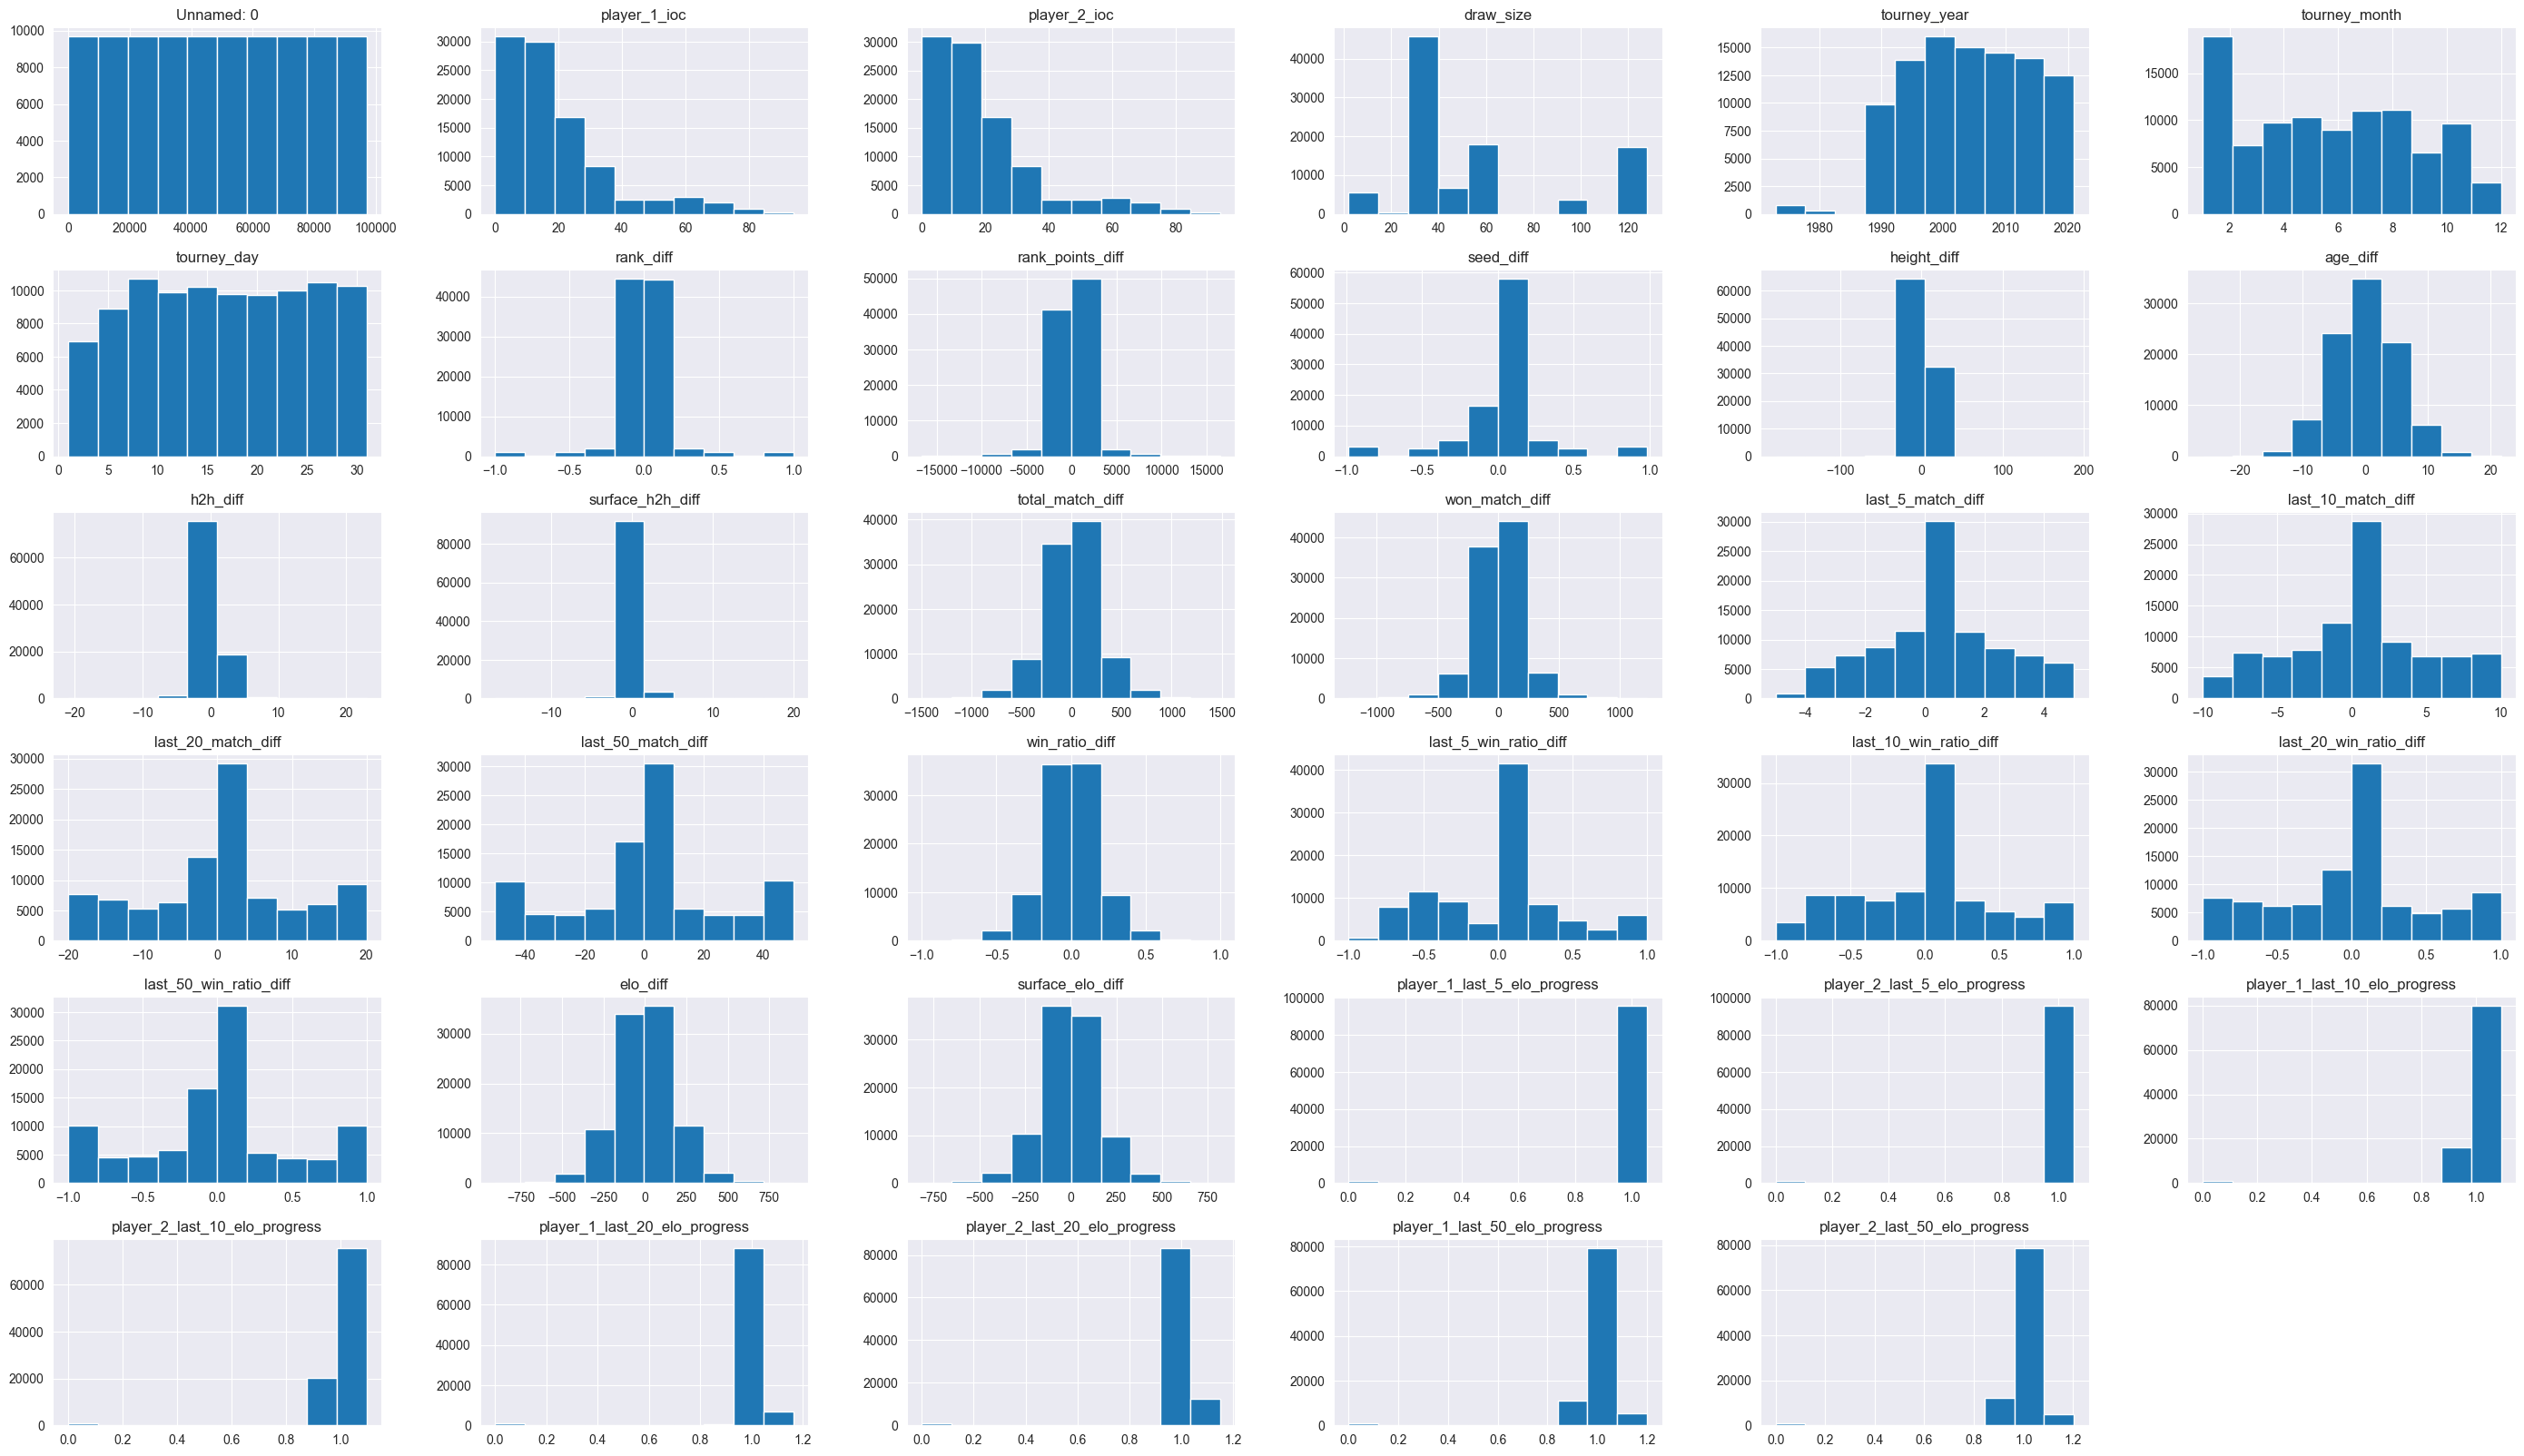

In [25]:
train_data = x_train.join(y_train)
train_data.hist(figsize=(35, 20))

<Axes: >

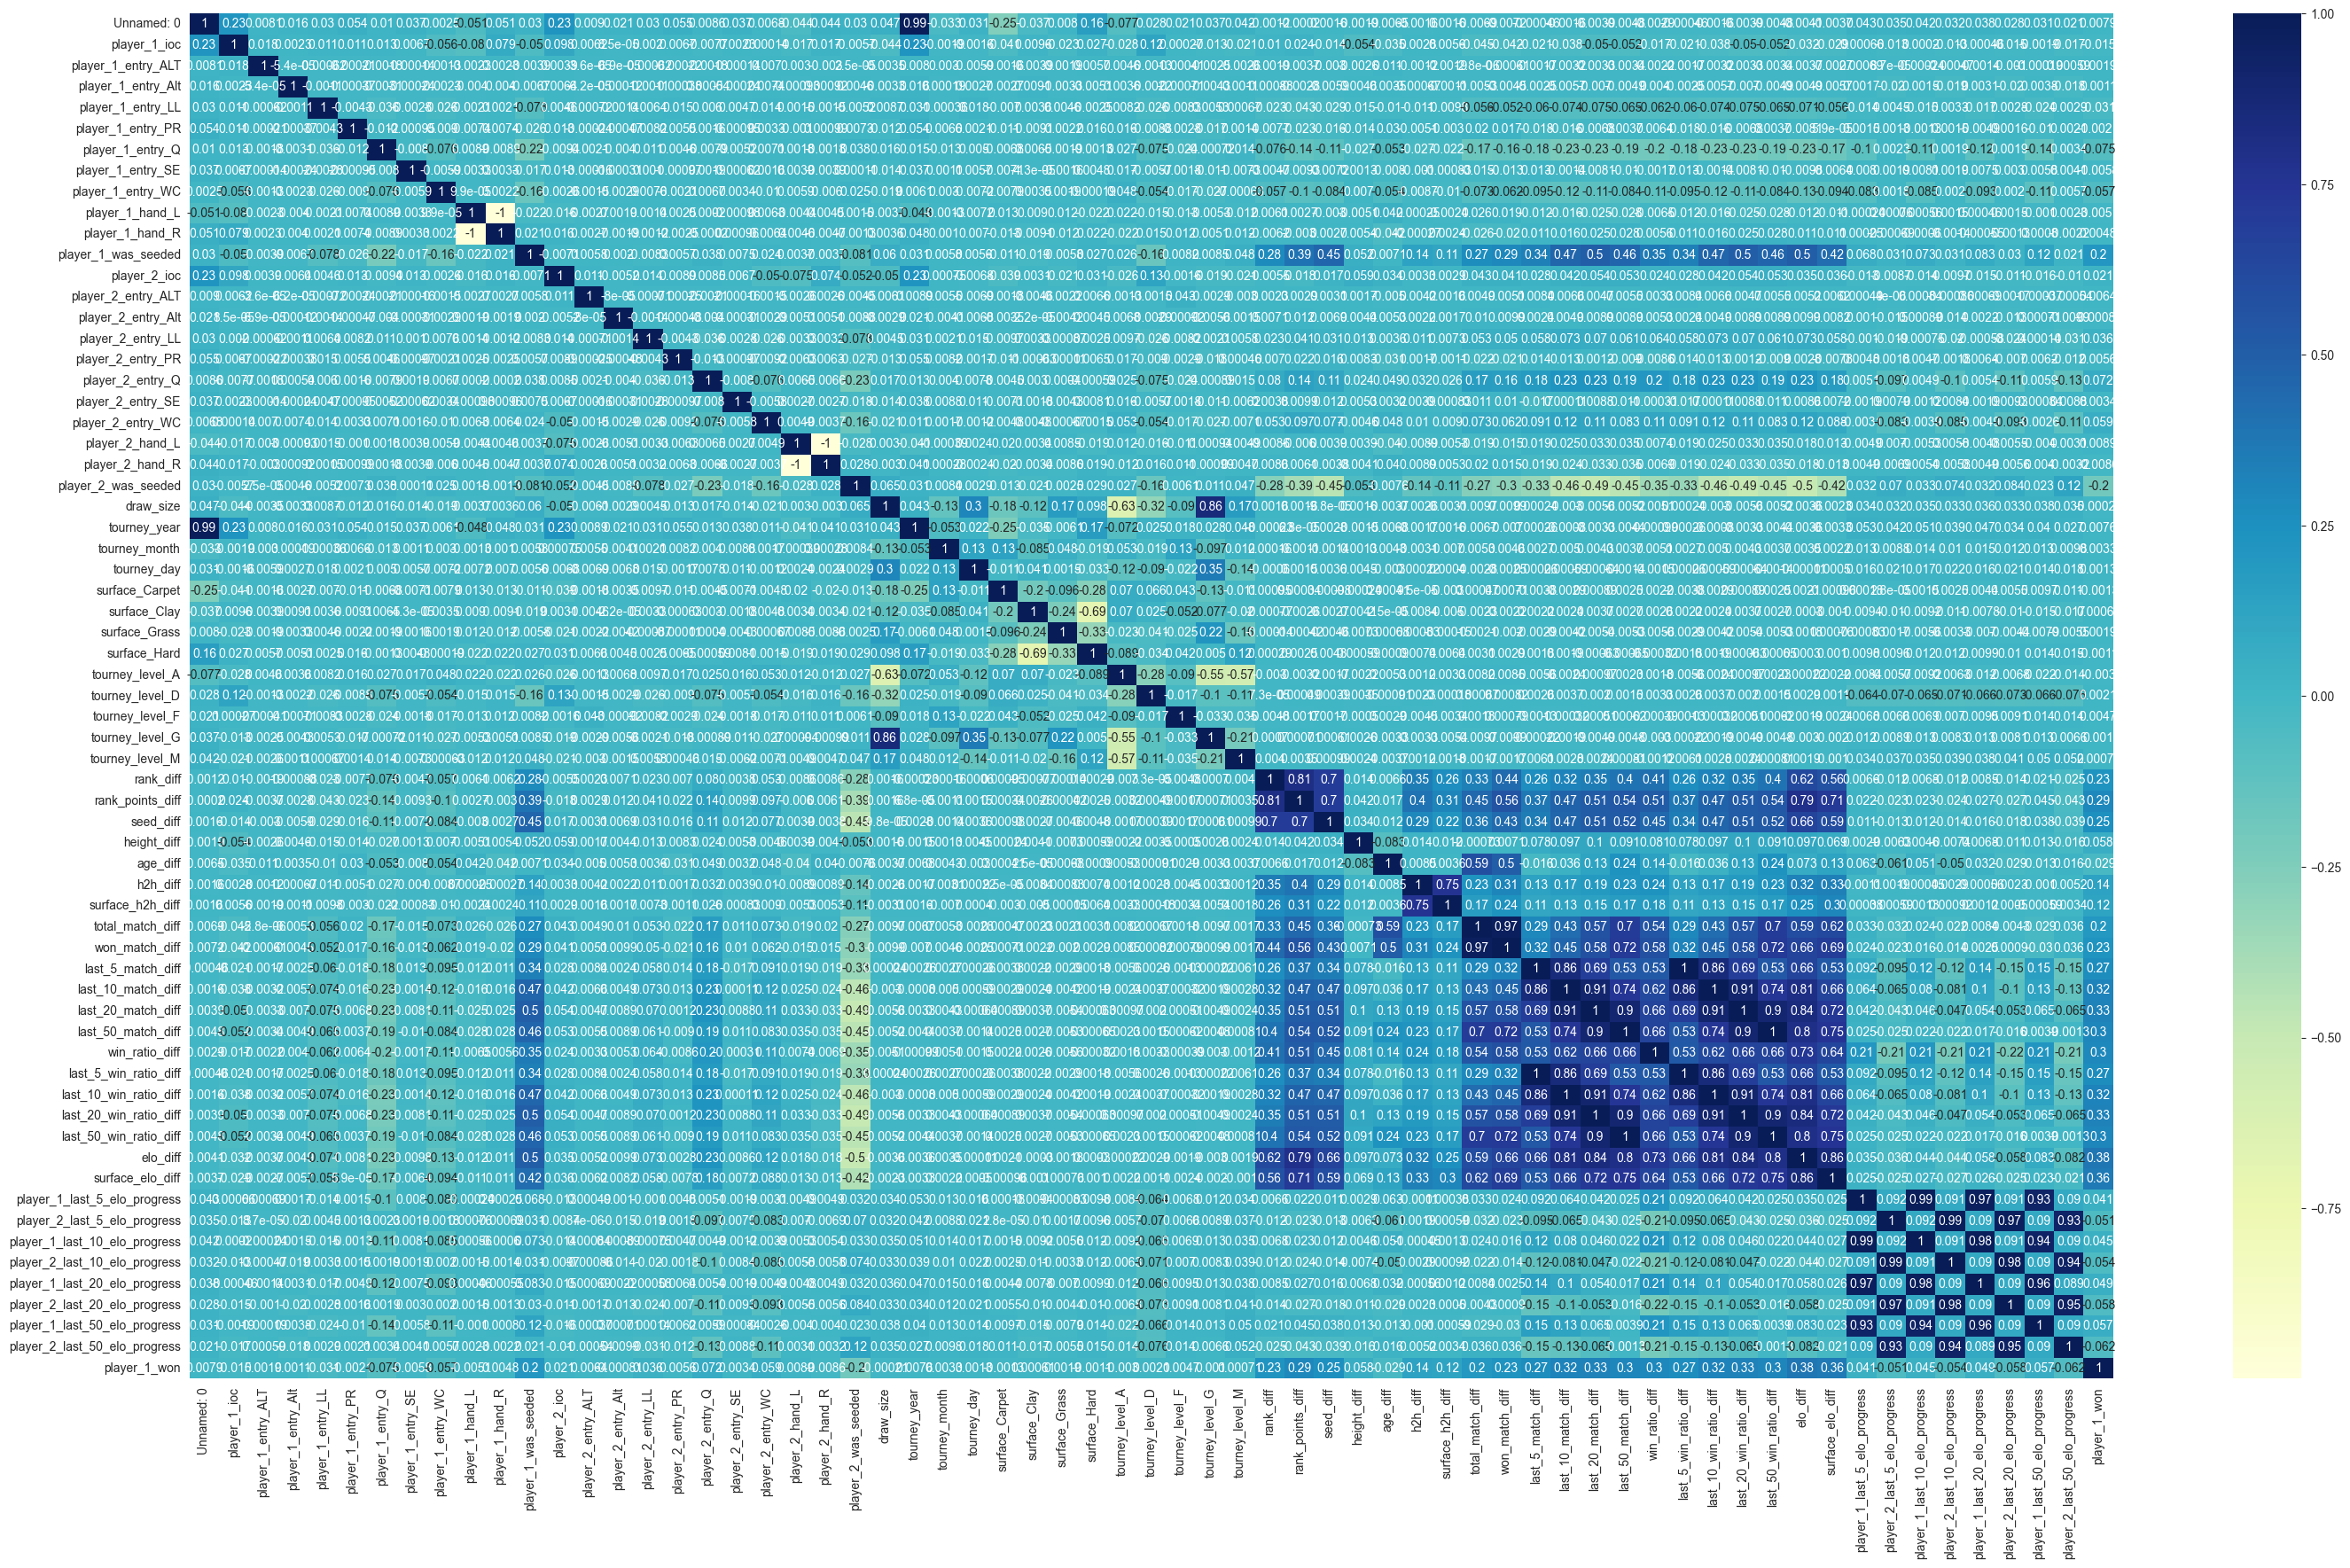

In [26]:
plt.figure(figsize=(35, 20))
sns.heatmap(train_data.corr(), annot = True, cmap = "YlGnBu")

In [27]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(random_state=42)
forest.fit(x_train, y_train)

RandomForestClassifier(random_state=42)

In [28]:
accuracy = forest.score(x_test, y_test)
print(f"Random Forest Model Accuracy -> {accuracy *100}%")

Random Forest Model Accuracy -> 65.11126248864669%


In [29]:
importances = forest.feature_importances_
feature_names = x_train.columns
importance_list = [[feature, importance] for feature, importance in
                   zip(feature_names, importances)]

importance_list.sort(key=lambda x: x[1], reverse=True)
for feature, importance in importance_list:
    print(f"{feature}: {importance * 100}%")

surface_elo_diff: 6.394485251782286%
elo_diff: 5.693118554370857%
rank_diff: 5.40606930179927%
rank_points_diff: 4.9116566038782095%
win_ratio_diff: 4.355051638796902%
age_diff: 3.402660341627519%
player_1_last_5_elo_progress: 3.1507094268932536%
player_2_last_5_elo_progress: 3.1450309721929033%
player_2_last_50_elo_progress: 3.1227370616744285%
player_1_last_20_elo_progress: 3.117585284184323%
player_1_last_50_elo_progress: 3.112528098263066%
player_2_last_10_elo_progress: 3.10505199555287%
player_1_last_10_elo_progress: 3.1044314941057682%
player_2_last_20_elo_progress: 3.104335538253461%
total_match_diff: 3.0842346893083423%
Unnamed: 0: 3.0153845350715374%
won_match_diff: 2.928507985847492%
tourney_day: 2.501627492550433%
height_diff: 2.4727998311999086%
player_2_ioc: 2.316493133074969%
player_1_ioc: 2.3047858094606624%
last_50_win_ratio_diff: 2.2796717612995065%
last_20_match_diff: 2.065632832468131%
tourney_year: 2.0626359319214664%
last_20_win_ratio_diff: 1.9380751157935436%
tour